In [1]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_images(image_list, title_list=[], grid='off'):
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(10*len(image_list), 10*1))
    if len(image_list) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
        if len(title_list) > 0:
            ax.set_title(title_list[i])
        ax.axis(grid)

In [3]:
def get_mission_file_path(mission_number):
    return '..\\missions\\mission_' + str(mission_number) + '\\mission_' + str(mission_number) + '_'

In [4]:
def get_mission_segmentation_file_path(mission_number):
    return '..\\missions\\mission_' + str(mission_number) + '_segmentation\\mission_' + str(mission_number) + '_'

# Goal

align mission to reference mission

In [5]:
# load missions
reference_mission = np.load(get_mission_file_path(2) + 'aligned_image.npy')
tobealigned_mission = cv2.imread(get_mission_segmentation_file_path(3) + 'bordered.png')

tobealigned_mission = cv2.resize(tobealigned_mission, (0,0), fx=.1, fy=.1)

print(reference_mission.shape)
print(tobealigned_mission.shape)

(543, 470, 3)
(719, 632, 3)


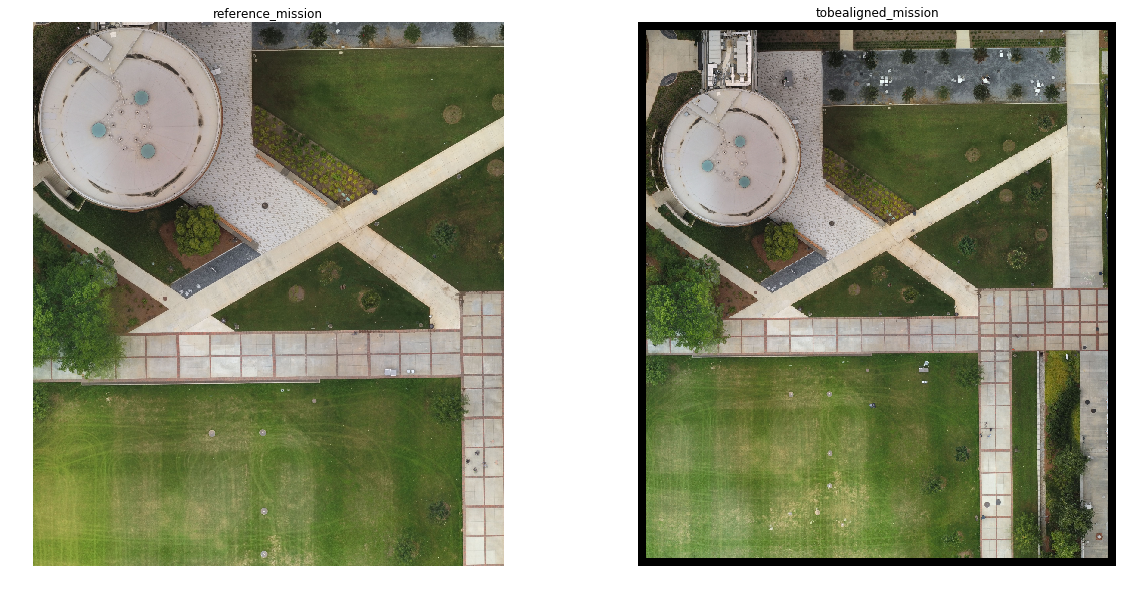

In [6]:
plot_images([reference_mission, tobealigned_mission], ['reference_mission', 'tobealigned_mission'])

In [14]:
from __future__ import print_function
import cv2
import numpy as np

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

def image_alignment(im1, im2):

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
#     cv2.imwrite('matches.jpg', imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h

In [13]:
aligned_mission, h = image_alignment(tobealigned_mission, reference_mission)

print("Estimated homography : \n",  h)

Estimated homography : 
 [[ 1.01647235e+00  1.47668094e-03 -2.78893403e+01]
 [ 6.21454078e-03  9.94576162e-01 -8.20634123e+01]
 [ 5.25616145e-05 -3.90454746e-05  1.00000000e+00]]


In [ ]:
print(reference_mission.shape)
print(tobealigned_mission.shape)
print(aligned_mission.shape)

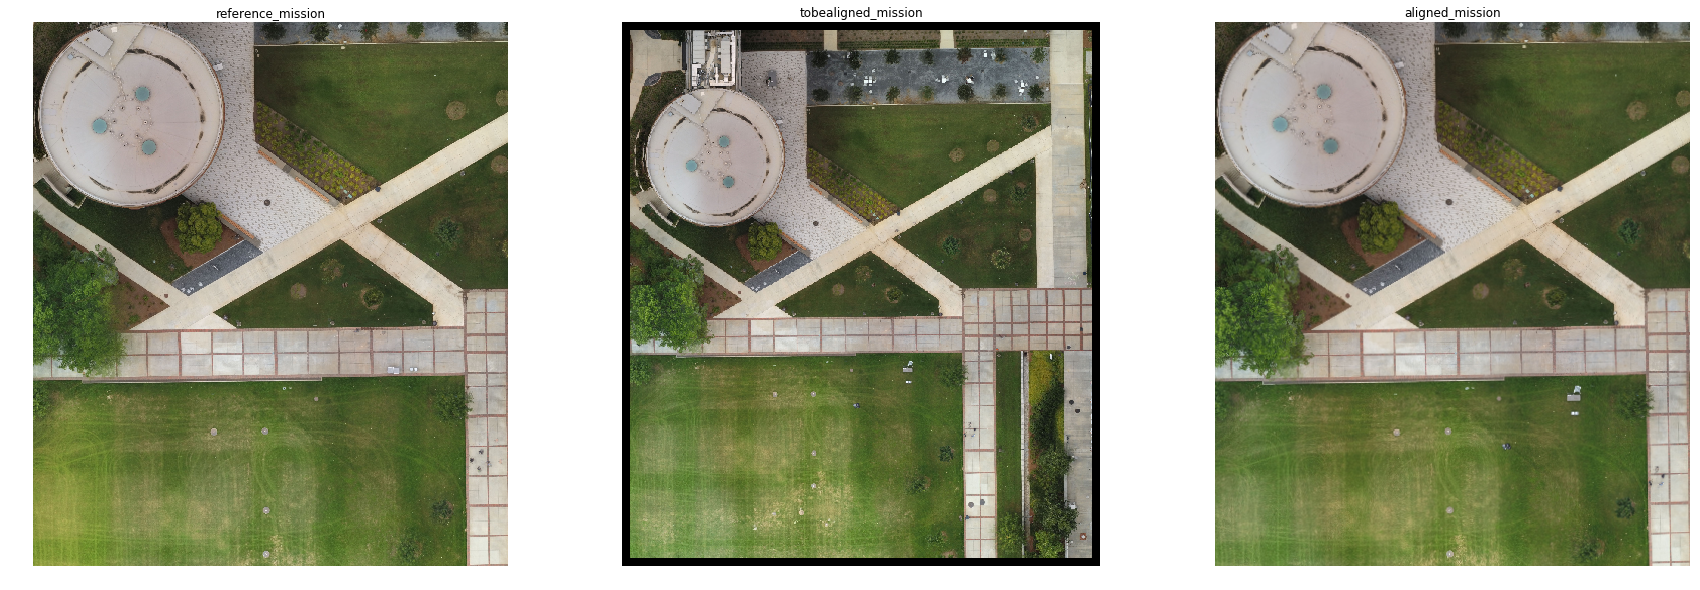

In [10]:
plot_images([reference_mission, tobealigned_mission, aligned_mission], ['reference_mission', 'tobealigned_mission', 'aligned_mission'])

In [11]:
h, w, c = reference_mission.shape
crop_h = 25 # fixed for our area we want based on reference mission
crop_w = 50

cropped_reference_mission = copy.deepcopy(reference_mission)[crop_h:h-crop_h, crop_w:w-crop_w, :]
cropped_aligned_mission = copy.deepcopy(aligned_mission)[crop_h:h-crop_h, crop_w:w-crop_w, :]

print(cropped_reference_mission.shape)
print(cropped_aligned_mission.shape)

(488, 370, 3)
(488, 370, 3)


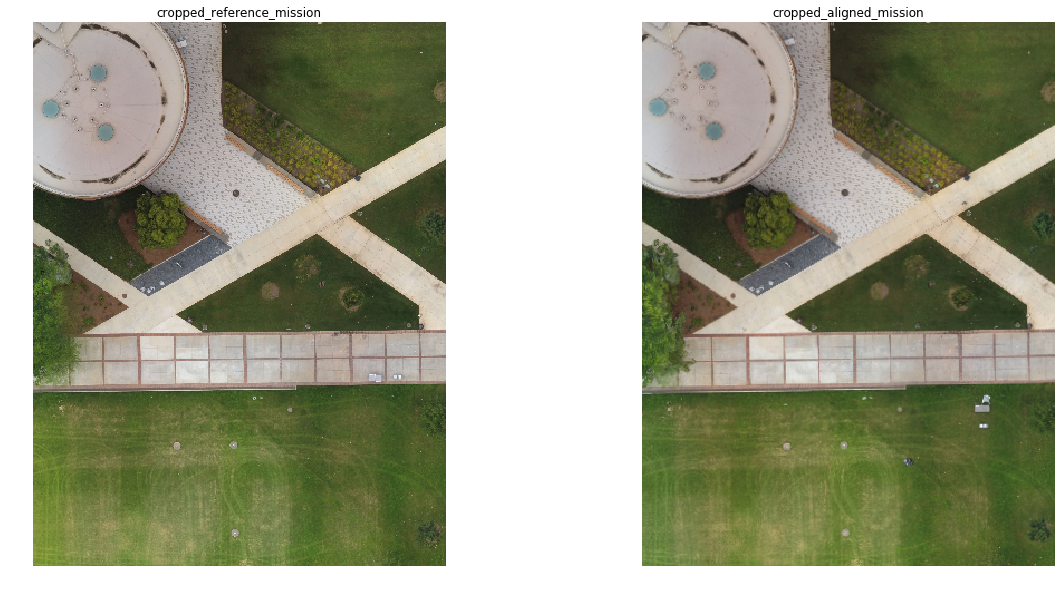

In [12]:
plot_images([cropped_reference_mission, cropped_aligned_mission], ['cropped_reference_mission', 'cropped_aligned_mission'])